## Instituto Federal da Paraíba
## Disciplina: Mineração de Dados
## Professor: Paulo Ribeiro
## Alunos: Filipe Salomão, Hércules de Sousa e Matheus Alves
##
## Projeto: Classificação de Gêneros Musicais

A biblioteca **_itertools_** do Python fornece ferramentas para criar e manipular iterações, ou seja, sequências de elementos. Ela oferece funções eficientes e flexíveis para combinar, permutar, filtrar e agrupar elementos de diferentes maneiras.

A biblioteca **_joblib_** do Python é uma ferramenta para facilitar a execução paralela e a serialização de tarefas intensivas em CPU. Ela fornece um mecanismo simples para paralelizar loops e funções, reduzindo o tempo de execução de tarefas demoradas. No nosso projeto, utilizamos a biblioteca joblib para serializar objetos Python, permitindo salvá-los em disco e recarregá-los posteriormente, o que pode ser útil para evitar o tempo de inicialização repetido ou compartilhar objetos entre processos.

A biblioteca **_lightgbm_** do Python é uma implementação eficiente e escalável do algoritmo de aprendizado de máquina chamado Gradient Boosting Machine (GBM). Ela é projetada para treinar modelos de aprendizado de máquina com rapidez, especialmente em conjuntos de dados grandes.

In [185]:
import itertools
import joblib
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

Lendo CSV com as características das músicas do nosso dataset:

In [2]:
df_features = pd.read_csv('./all_features.csv', index_col=False)

In [3]:
df_features.head()

,spectral_centroid_max,spectral_centroid_min,spectral_centroid_mean,spectral_centroid_std,spectral_centroid_kurtosis,spectral_centroid_skew,spectral_rolloff_max,spectral_rolloff_min,spectral_rolloff_mean,spectral_rolloff_std,...,mfcc_11_kurtosis,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo,label
0,4737.508153,635.664676,2098.726133,556.496663,2.887029,1.283600,9130.078125,925.927734,4514.561770,1372.578815,...,-0.086715,-0.088010,32.658615,-31.948511,-5.576648,9.920987,-0.200280,0.234563,143.554688,forró
1,5339.076724,1019.369702,2294.895607,604.767987,1.803070,0.943630,9130.078125,1722.656250,4914.999411,1341.457851,...,0.120776,-0.207388,21.607838,-36.618702,-4.257775,9.034795,-0.080838,0.118976,143.554688,forró
2,6613.348219,1526.374864,2857.957595,685.797071,3.499504,1.245568,9474.609375,2648.583984,6027.380220,1304.601244,...,-0.253195,0.186958,32.782486,-35.293335,-7.233448,11.249509,-0.106279,0.236294,151.999081,forró
3,6935.364306,945.116845,2439.278264,730.595169,4.671441,1.223784,9840.673828,1184.326172,5551.766429,1564.960933,...,0.052664,-0.347261,28.608442,-36.924840,-3.531663,9.956684,0.135261,-0.020543,107.666016,forró
4,7086.838756,928.772862,2541.888664,744.284935,2.716824,1.082830,9969.873047,1162.792969,6118.729668,1422.390345,...,-0.254407,-0.014688,29.134048,-33.681553,-3.894992,9.132825,0.035545,0.014757,135.999178,forró


Obtendo **_X_**, onde queremos apenas as características, sem os gêneros (labels).

In [4]:
X = df_features.drop(['label'], axis=1).values

Obtendo **_y_**, onde queremos apenas os gêneros.

In [5]:
y = df_features['label'].values

Separando os dados de treinamento e teste. Utilizamos o **_stratify_** para ajudar a evitar um viés na distribuição das classes nos conjuntos de treinamento e teste.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

Agora testamos o conjunto de dados treinado em diferentes modelos:

# Regressão Logística

Criando possíveis valores para os parâmetros.

**'cls__penalty'**: Especifica a penalidade a ser aplicada na regressão logística. São testadas duas opções: **'l2'** (regularização L2) e **'none'** (sem penalidade).

**'cls__C'**: Controla a força da regularização. São testados três valores: **0.5**, **1**, e **2**. Valores menores indicam uma regularização mais forte, enquanto valores maiores indicam uma regularização mais fraca.

**'cls__max_iter'**: Define o número máximo de iterações para a convergência do algoritmo. São testados dois valores: **500** e **1000**. Esse parâmetro é relevante principalmente para garantir que o algoritmo tenha tempo suficiente para convergir.

In [7]:
params_lr = {
    'cls__penalty': ['l2', 'none'],
    'cls__C': [0.5, 1, 2],
    'cls__max_iter': [500, 1000]
}

Criando Pipeline.

**'scale'**: A primeira etapa é a normalização dos dados usando **_StandardScaler_**. Isso é importante para garantir que todas as características tenham a mesma escala, o que pode melhorar o desempenho do modelo.

**'var_threshold'**: A próxima etapa é a seleção de características com base na variância. A classe **_VarianceThreshold_** remove as características cuja variância não atinge um certo limite. Nesse caso, o limite é definido como **80%** da variância máxima possível. Essa etapa ajuda a reduzir a dimensionalidade dos dados, removendo características com pouca variabilidade.

**'feature_selection'**: Em seguida, é realizada uma seleção de características usando a técnica **_SelectFromModel_**. Nessa etapa, é utilizado um modelo **_LGBMClassifier_** do pacote _lightgbm_ para avaliar a importância das características. Apenas as características consideradas importantes pelo modelo são mantidas para o próximo estágio.

**'cls'**: Por fim, temos a etapa de modelagem, onde é usado um modelo de Regressão Logística **_(LogisticRegression)_** para realizar a classificação.

In [8]:
pipeline_lr = Pipeline([
    ('scale', StandardScaler()),
    ('var_threshold', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', LogisticRegression())
])

O código a seguir é usado para realizar uma busca em grade para encontrar a melhor combinação de hiperparâmetros para um modelo de Regressão Logística dentro do pipeline.

Alguns parâmetros são passados para o GridSearchCV:

**_pipeline_**: É o pipeline que contém todas as etapas de pré-processamento e modelagem definidas anteriormente.

**_params_**: É um dicionário que especifica os parâmetros e os valores que serão testados durante a busca em grade.

**_scoring_**: Especifica a métrica de avaliação que será usada para determinar a melhor combinação de hiperparâmetros. Neste caso, a acurácia é escolhida como a métrica de avaliação, que mede a proporção de previsões corretas do modelo.

**_n_jobs_**: Define o número de trabalhos em paralelo a serem executados durante a busca em grade. Nesse caso, 6 trabalhos paralelos serão executados, o que pode acelerar o processo de busca em grade se houver recursos de processamento disponíveis.

**_cv_**: Especifica a estratégia de validação cruzada a ser usada durante a busca em grade. Neste caso, é usada a **validação cruzada com 5 dobras (5-fold cross-validation)**, que divide os dados em 5 partes iguais e executa 5 iterações de treinamento e avaliação, utilizando uma parte diferente como conjunto de validação em cada iteração.

In [9]:
grid_lr = GridSearchCV(pipeline_lr, params_lr, scoring='accuracy', n_jobs=6, cv=5)

Realizando fit da grade com base no conjunto de dados:

In [10]:
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_threshold',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', LogisticRegression())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1, 2], 'cls__max_iter': [500, 1000],
                         'cls__penalty': ['l2', 'none']},
             scoring='accuracy')

Realizando predições com base em **_X_test_**:

In [11]:
predictions_lr = grid_lr.predict(X_test)

Visualizando scores no conjunto de validação e no conjunto de teste:

In [12]:
print(f"Melhor score no conjunto de validação (acurácia) = {grid_lr.best_score_}")
print(f"Melhor score no conjunto de teste (acurácia) = {accuracy_score(y_test, predictions_lr)}")

Melhor score no conjunto de validação (acurácia) = 0.8063492063492064
Melhor score no conjunto de teste (acurácia) = 0.780952380952381


Visualizando os melhores valores para os parâmetros utilizados:

In [13]:
grid_lr.best_params_

{'cls__C': 0.5, 'cls__max_iter': 500, 'cls__penalty': 'l2'}

# Árvore de Decisão

Criando possíveis valores para os parâmetros:

**'cls__criterion'**: Esse parâmetro define a medida de qualidade usada para fazer a divisão dos nós da árvore. Existem duas opções disponíveis:

- **'gini'**: Utiliza o índice de impureza de Gini para medir a pureza dos nós da árvore. É uma medida comum e eficiente para árvores de decisão.

- **'entropy'**: Utiliza o critério de ganho de informação (entropia) para medir a pureza dos nós. Esse critério tende a favorecer divisões que resultam em classes mais homogêneas nos nós filhos.

**'cls__splitter'**: Esse parâmetro determina a estratégia usada para escolher a melhor divisão nos nós da árvore. Existem duas opções disponíveis:

- **'best'**: Seleciona a melhor divisão com base em algum critério de qualidade, como o ganho de informação ou a impureza de Gini.

- **'random'**: Escolhe aleatoriamente uma das divisões com a mesma qualidade máxima. Essa abordagem pode ser útil para aumentar a aleatoriedade e diversidade da árvore.

In [14]:
params_dt = {
    'cls__criterion': ['gini', 'entropy'],
    'cls__splitter': ['best', 'random'],
}

Criando Pipeline:

In [15]:
pipeline_dt = Pipeline([
    ('var_threshold', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', DecisionTreeClassifier())
])

Criando busca em grade:

In [16]:
grid_dt = GridSearchCV(pipeline_dt, params_dt, scoring='accuracy', n_jobs=6, cv=5)

Realizando fit:

In [17]:
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_threshold',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', DecisionTreeClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__splitter': ['best', 'random']},
             scoring='accuracy')

Realizando predições:

In [18]:
predictions_dt = grid_dt.predict(X_test)

Visualizando scores:

In [19]:
print(f"Melhor score no conjunto de validação (acurácia) = {grid_dt.best_score_}")
print(f"Melhor score no conjunto de teste (acurácia) = {accuracy_score(y_test, predictions_dt)}")

Melhor score no conjunto de validação (acurácia) = 0.6126984126984127
Melhor score no conjunto de teste (acurácia) = 0.5619047619047619


Visualizando melhores valores para os parâmetros:

In [20]:
grid_dt.best_params_

{'cls__criterion': 'entropy', 'cls__splitter': 'best'}

# Floresta Aleatória

Criando possíveis valores para os parâmetros:

**'cls__n_estimators'**: define o número de árvores a serem criadas pelo _RandomForestClassifier_.

**'cls__criterion'**: define a medida de qualidade da divisão de um nó, sendo **'gini'** para o índice Gini e **'entropy'** para a entropia.

**'cls__max_depth'**: define a profundidade máxima da árvore. Um valor None significa que os nós são expandidos até que todas as folhas contenham menos de _min_samples_split_ amostras.

In [21]:
params_rf = {
    "cls__n_estimators": [100, 250, 500, 1000],
    "cls__criterion": ["gini", "entropy"],
    "cls__max_depth": [5, 7, None]
}

Criando Pipeline:

In [22]:
pipeline_rf = Pipeline([
    ('var_threshold', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', RandomForestClassifier())
])

Criando busca em grade:

In [23]:
grid_rf = GridSearchCV(pipeline_rf, params_rf, scoring='accuracy', n_jobs=6, cv=5)

Realizando fit:

In [24]:
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_threshold',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', RandomForestClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__max_depth': [5, 7, None],
                         'cls__n_estimators': [100, 250, 500, 1000]},
             scoring='accuracy')

Realizando predições:

In [25]:
predictions_rf = grid_rf.predict(X_test)

Visualizando scores:

In [26]:
print(f"Melhor score no conjunto de validação (acurácia) = {grid_rf.best_score_}")
print(f"Melhor score no conjunto de teste (acurácia) = {accuracy_score(y_test, predictions_rf)}")

Melhor score no conjunto de validação (acurácia) = 0.7936507936507937
Melhor score no conjunto de teste (acurácia) = 0.8


Visualizando os melhores valores para os parâmetros:

In [27]:
grid_rf.best_params_

{'cls__criterion': 'gini', 'cls__max_depth': None, 'cls__n_estimators': 500}

# SVM

Criando possíveis valores para os parâmetros:

**'cls__C'**: é um parâmetro de regularização que controla a penalidade por erro de classificação. Valores menores de C indicam uma penalidade maior, o que pode resultar em uma margem de decisão mais ampla, permitindo mais pontos de dados classificados incorretamente. Valores maiores de C, por outro lado, indicam uma penalidade menor e podem resultar em uma margem de decisão mais restrita, tentando classificar corretamente a maioria dos pontos de dados de treinamento. Os valores especificados em _params_svm_ para o parâmetro C são **[0.5, 1, 2, 5]**.

**'cls__kernel'** é o tipo de kernel a ser usado no SVM. O kernel é responsável por transformar os dados de entrada em um espaço de maior dimensão, onde a separação entre classes pode ser mais eficiente. Existem diferentes tipos de kernel, sendo os mais comuns:

- **'rbf'**: Radial Basis Function, também conhecido como kernel Gaussiano, é frequentemente usado como o kernel padrão. É útil para classificações não lineares.

- **'linear'**: É um kernel linear simples que não faz nenhuma transformação dos dados.

- **'sigmoid'**: Usado principalmente em problemas de classificação binária. É semelhante à função de ativação sigmoid em redes neurais.

In [28]:
params_svm = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

Criando Pipeline:

In [29]:
pipeline_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_threshold', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

Criando busca em grade:

In [30]:
grid_svm = GridSearchCV(pipeline_svm, params_svm, scoring='accuracy', n_jobs=6, cv=5)

Realizando fit:

In [31]:
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_threshold',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', SVC())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1, 2, 5],
                         'cls__kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='accuracy')

Realizando predições:

In [32]:
predictions_svm = grid_svm.predict(X_test)

Visualizando scores:

In [33]:
print(f"Melhor score no conjunto de validação (acurácia) = {grid_svm.best_score_}")
print(f"Melhor score no conjunto de teste (acurácia) = {accuracy_score(y_test, predictions_svm)}")

Melhor score no conjunto de validação (acurácia) = 0.834920634920635
Melhor score no conjunto de teste (acurácia) = 0.7952380952380952


Visualizando os melhores valores para os parâmetros:

In [34]:
grid_svm.best_params_

{'cls__C': 1, 'cls__kernel': 'rbf'}

# K Vizinhos

Criando possíveis valores para os parâmetros:

**'cls__n_neighbors'**: especifica o número de vizinhos a serem considerados para a classificação de um ponto. É um parâmetro importante do algoritmo KNN, onde um valor maior indica que um maior número de vizinhos será considerado ao fazer a classificação.

**'cls__weights'**: define a função de peso utilizada para atribuir importância aos vizinhos. Existem duas opções principais:

- **'uniform'**: Todos os vizinhos têm o mesmo peso, ou seja, eles contribuem igualmente para a classificação do ponto em questão.
- **'distance'**: Os vizinhos são ponderados de acordo com a sua distância do ponto a ser classificado. Vizinhos mais próximos têm um peso maior em comparação com vizinhos mais distantes.

**'cls__algorithm'**: especifica o algoritmo a ser usado para calcular os vizinhos mais próximos. As opções disponíveis são:

- **'auto'**: O algoritmo escolhe automaticamente o melhor algoritmo com base nos dados de entrada e nos parâmetros fornecidos.

- **'ball_tree'**: Utiliza a estrutura de dados Ball Tree para encontrar os vizinhos mais próximos.

- **'kd_tree'**: Utiliza a estrutura de dados KD Tree para encontrar os vizinhos mais próximos.

- **'brute'**: Utiliza uma pesquisa bruta linear para encontrar os vizinhos mais próximos.

In [35]:
params_knn = {
    "cls__n_neighbors": [1, 2, 5, 10],
    "cls__weights": ['uniform', 'distance'],
    "cls__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
}

Criando Pipeline:

In [36]:
pipeline_knn = Pipeline([
    ('scale', StandardScaler()),
    ('var_threshold', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', KNeighborsClassifier())
])

Criando busca em grade:

In [37]:
grid_knn = GridSearchCV(pipeline_knn, params_knn, scoring='accuracy', n_jobs=6, cv=5)

Realizando fit:

In [38]:
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_threshold',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', KNeighborsClassifier())]),
             n_jobs=6,
             param_grid={'cls__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'cls__n_neighbors': [1, 2, 5, 10],
                         'cls__weights': ['uniform', 'distance']},
             scoring='accuracy')

Realizando predições:

In [39]:
predictions_knn = grid_knn.predict(X_test)

Visualizando scores:

In [40]:
print(f"Melhor score no conjunto de validação (acurácia) = {grid_knn.best_score_}")
print(f"Melhor score no conjunto de teste (acurácia) = {accuracy_score(y_test, predictions_knn)}")

Melhor score no conjunto de validação (acurácia) = 0.7555555555555555
Melhor score no conjunto de teste (acurácia) = 0.7523809523809524


Visualizando os melhores valores para os parâmetros:

In [41]:
grid_knn.best_params_

{'cls__algorithm': 'auto', 'cls__n_neighbors': 10, 'cls__weights': 'distance'}

# Naive Bayes

Criando possíveis valores para os parâmetros:

**'cls__priors'**: especifica as probabilidades a priori das classes. Nesse caso, o valor **None** indica que as probabilidades a priori serão estimadas a partir dos dados.

**'cls__var_smoothing'**: define a suavização (smoothing) aplicada às estimativas de variância dos recursos. A suavização é usada para evitar a ocorrência de probabilidade zero quando um determinado recurso não aparece em uma classe específica. Valores menores de var_smoothing resultam em uma suavização mais forte.

In [42]:
params_nb = {
    "cls__priors": [None],
    "cls__var_smoothing": [1e-7, 1e-8, 1e-9]
}

Criando Pipeline:

In [43]:
pipeline_nb = Pipeline([
    ('scale', StandardScaler()),
    ('var_threshold', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', GaussianNB())
])

Criando busca em grade:

In [44]:
grid_nb = GridSearchCV(pipeline_nb, params_nb, scoring='accuracy', n_jobs=6, cv=5)

Realizando fit:

In [45]:
grid_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_threshold',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', GaussianNB())]),
             n_jobs=6,
             param_grid={'cls__priors': [None],
                         'cls__var_smoothing': [1e-07, 1e-08, 1e-09]},
             scoring='accuracy')

Realizando predições:

In [46]:
predictions_nb = grid_nb.predict(X_test)

Visualizando scores:

In [47]:
print(f"Melhor score no conjunto de validação (acurácia) = {grid_nb.best_score_}")
print(f"Melhor score no conjunto de teste (acurácia) = {accuracy_score(y_test, predictions_nb)}")

Melhor score no conjunto de validação (acurácia) = 0.7476190476190476
Melhor score no conjunto de teste (acurácia) = 0.7380952380952381


Visualizando os melhores valores para os parâmetros:

In [48]:
grid_nb.best_params_

{'cls__priors': None, 'cls__var_smoothing': 1e-07}

A função **_plot_confusion_matrix_** é usada para exibir e plotar a matriz de confusão. A matriz de confusão é uma tabela que mostra o desempenho de um modelo de classificação, comparando as classes verdadeiras com as classes previstas.

In [49]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Obtendo os nomes dos gêneros a partir do DataFrame:

In [50]:
genres = df_features['label'].unique()

### Matriz de confusão da regressão logística

In [51]:
cm_lr = confusion_matrix(y_test, predictions_lr)

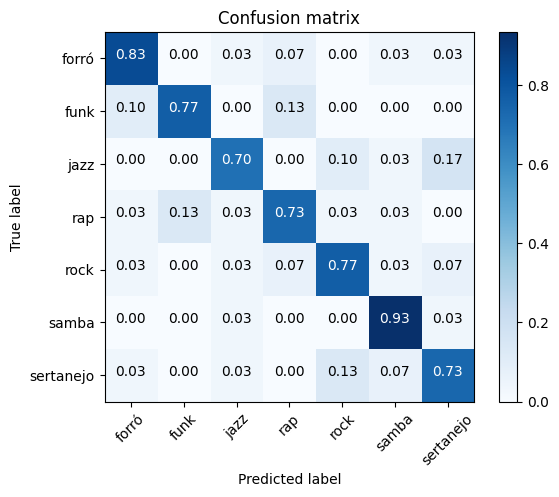

In [52]:
plot_confusion_matrix(cm_lr, genres, normalize=True)

### Matriz de confusão da árvore de decisão

In [53]:
cm_dt = confusion_matrix(y_test, predictions_dt)

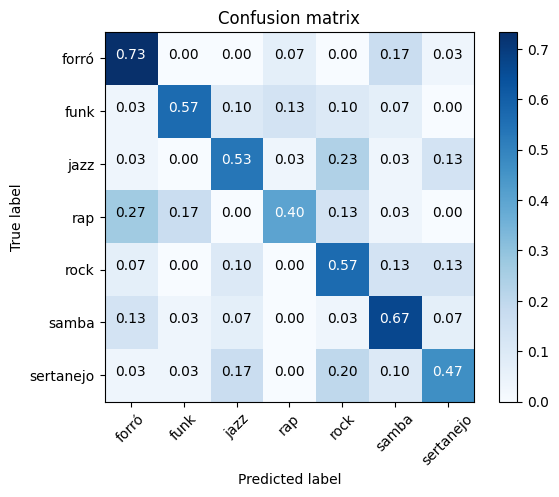

In [54]:
plot_confusion_matrix(cm_dt, genres, normalize=True)

### Matriz de confusão da floresta aleatória

In [55]:
cm_rf = confusion_matrix(y_test, predictions_rf)

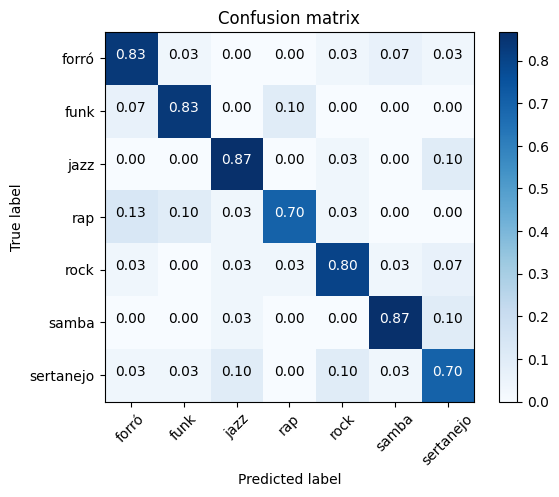

In [56]:
plot_confusion_matrix(cm_rf, genres, normalize=True)

### Matriz de confusão da SVM

In [57]:
cm_svm = confusion_matrix(y_test, predictions_svm)

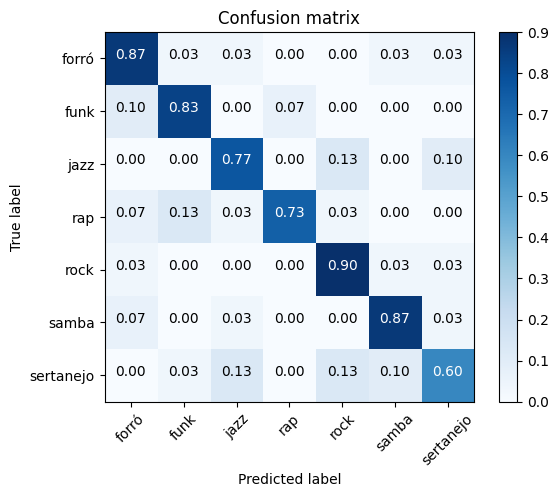

In [58]:
plot_confusion_matrix(cm_svm, genres, normalize=True)

### Matriz de confusão do K Vizinhos

In [59]:
cm_knn = confusion_matrix(y_test, predictions_knn)

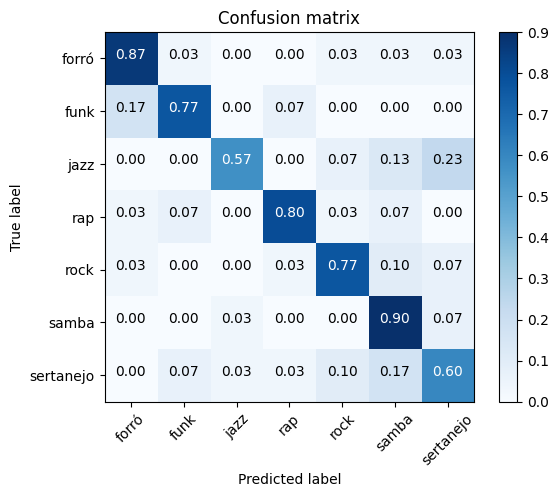

In [60]:
plot_confusion_matrix(cm_knn, genres, normalize=True)

### Matriz de confusão do Naive Bayes

In [61]:
cm_nb = confusion_matrix(y_test, predictions_nb)

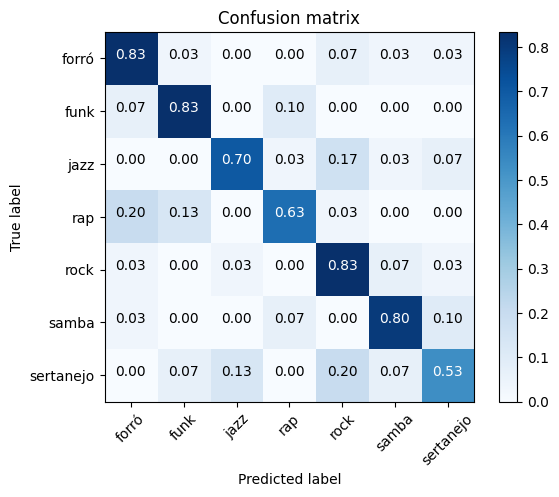

In [62]:
plot_confusion_matrix(cm_nb, genres, normalize=True)

### Comparação entre os scores dos modelos

In [194]:
names = ['Regressão Logística', 'Árvore de Decisão', 'Floresta Aleatória', 'SVM', 'K Vizinhos', 'Naive Bayes']

In [195]:
scores = [
    grid_lr.best_score_,
    grid_dt.best_score_,
    grid_rf.best_score_,
    grid_svm.best_score_,
    grid_knn.best_score_,
    grid_nb.best_score_
]

In [196]:
test_accuracy = [
    accuracy_score(y_test, predictions_lr),
    accuracy_score(y_test, predictions_dt),
    accuracy_score(y_test, predictions_rf),
    accuracy_score(y_test, predictions_svm),
    accuracy_score(y_test, predictions_knn),
    accuracy_score(y_test, predictions_nb)
]

In [197]:
test_precision = [
    precision_score(y_test, predictions_lr, average='macro'),
    precision_score(y_test, predictions_dt, average='macro'),
    precision_score(y_test, predictions_rf, average='macro'),
    precision_score(y_test, predictions_svm, average='macro'),
    precision_score(y_test, predictions_knn, average='macro'),
    precision_score(y_test, predictions_nb, average='macro')
]

In [198]:
test_f1_score = [
    f1_score(y_test, predictions_lr, average='macro'),
    f1_score(y_test, predictions_dt, average='macro'),
    f1_score(y_test, predictions_rf, average='macro'),
    f1_score(y_test, predictions_svm, average='macro'),
    f1_score(y_test, predictions_knn, average='macro'),
    f1_score(y_test, predictions_nb, average='macro')
]

In [199]:
scores = [x * 100 for x in scores]
test_accuracy = [x * 100 for x in test_accuracy]
test_precision = [x * 100 for x in test_precision]
test_f1_score = [x * 100 for x in test_f1_score]

In [200]:
sorted_models_scores = sorted(zip(names, scores), key=lambda d: d[1])
sorted_models_accuracy = sorted(zip(names, test_accuracy), key=lambda d: d[1])
sorted_models_precision = sorted(zip(names, test_precision), key=lambda d: d[1])
sorted_models_f1_score = sorted(zip(names, test_f1_score), key=lambda d: d[1])

In [201]:
sorted_names_scores, sorted_scores = zip(*sorted_models_scores)
sorted_names_accuracy, sorted_accuracy = zip(*sorted_models_accuracy)
sorted_names_precision, sorted_precision = zip(*sorted_models_precision)
sorted_names_f1_score, sorted_f1_score = zip(*sorted_models_f1_score)

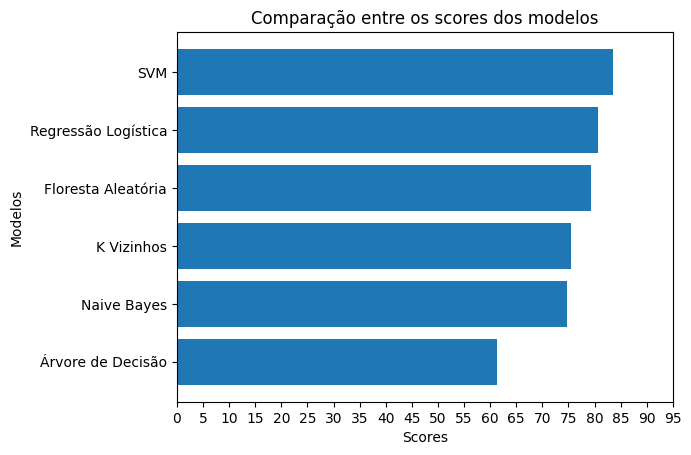

In [202]:
plt.barh(sorted_names_scores, sorted_scores)

plt.xlabel('Scores')
plt.ylabel('Modelos')
plt.title('Comparação entre os scores dos modelos')

ticks = np.arange(0, 100, 5)

plt.xticks(ticks);

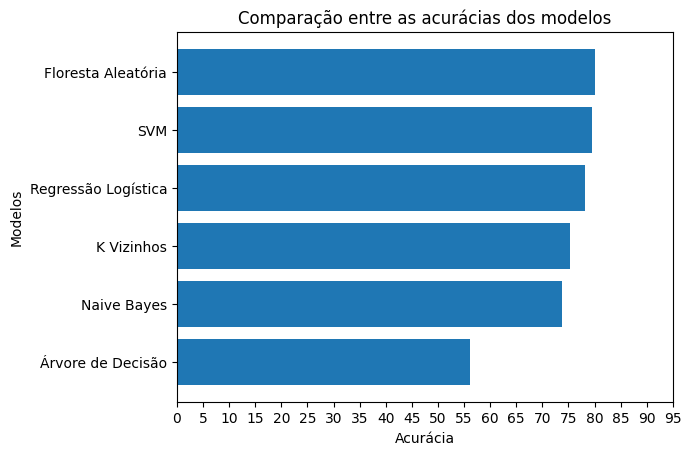

In [203]:
plt.barh(sorted_names_accuracy, sorted_accuracy)

plt.xlabel('Acurácia')
plt.ylabel('Modelos')
plt.title('Comparação entre as acurácias dos modelos')

ticks = np.arange(0, 100, 5)

plt.xticks(ticks);

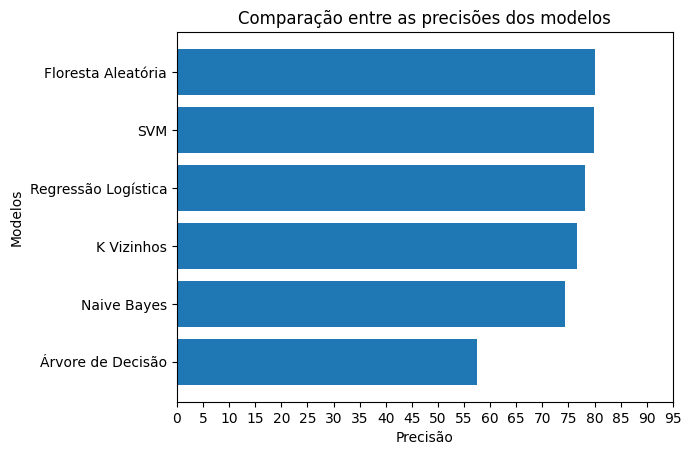

In [204]:
plt.barh(sorted_names_precision, sorted_precision)

plt.xlabel('Precisão')
plt.ylabel('Modelos')
plt.title('Comparação entre as precisões dos modelos')

ticks = np.arange(0, 100, 5)

plt.xticks(ticks);

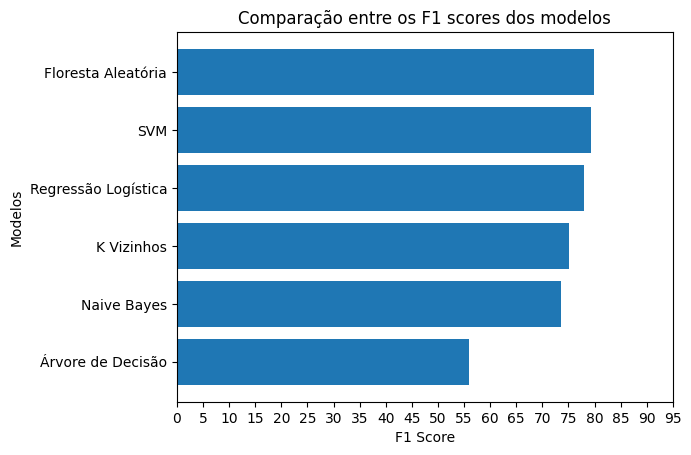

In [205]:
plt.barh(sorted_names_f1_score, sorted_f1_score)

plt.xlabel('F1 Score')
plt.ylabel('Modelos')
plt.title('Comparação entre os F1 scores dos modelos')

ticks = np.arange(0, 100, 5)

plt.xticks(ticks);

Salvando os modelos em arquivos com a biblioteca _joblib_:

In [63]:
# joblib.dump(grid_lr, "./models/pipe_lr.joblib")
# joblib.dump(grid_dt, "./models/pipe_dt.joblib")
# joblib.dump(grid_rf, "./models/pipe_rf.joblib")
# joblib.dump(grid_svm, "./models/pipe_svm.joblib")
# joblib.dump(grid_knn, "./models/pipe_knn.joblib")
# joblib.dump(grid_nb, "./models/pipe_nb.joblib")